# Getting started with the `Rhapsopy` package


`Rhapsopy` (**R**eally **H**igh-order **A**da**P**tive coupling for **S**imulation **O**rchestration in **Py**thon) provides a framework to dynamically couple existing simulation codes, as may be required for complex multiphysics simulations.

In this notebook, we will take a simple example to introduce the various concepts and demonstrate how to use our package.


## Principles of code coupling
The present framework is suited to coupled systems that take the following form :
\begin{equation}
    \begin{cases}
        \dot{x_1} &=  f_1(x_1, u_1, t) \\
        \dot{x_2} &=  f_2(x_2, u_2, t) \\
        ... \\
        \dot{x_N} &=  f_N(x_N, u_N, t) \\
    \end{cases}
\end{equation}
where the inputs $u_i$ have the general form $u_i = g_i(x_1, .., x_N)$.

Many multiphysics problems can be recast in this form. In general, each $x_i$ represents the state vector associated with one subsystem (fluid model, solid mechanics model...). The coupling variables are such that their dimension $\sum_i dim(u_i)$ is usually much lower than the number of unkowns $\sum_i dim(x_i)$. This assumption may not be always be true, e.g. for volume-coupled codes. One should keep in mind that such use cases may result in poor overall performance.

The toy model studied further on gives a basic example of such a system, and other more complex examples are included in the repository.

Simulation the coupled system as a single large system (*monolithic approach*) can be cumbersome, especially if the various subsystems $x_i$ involve different physics (mechanics, fluid dynamics, heat conduction...).
It is better to try and reuse existing specialised codes to simulate each subsystem.
To perform a coupled simulation, these codes must then be connected dynamically, for instance via proper boundary condition updates.

The traditional approach is to let each code integrate its own subsytem for a small time interval from $t_n$ to $t_{n+1}=t_n + \Delta t$, assuming that all other subsystems are frozen. The following scheme is an example of this typical approach:
$$x_{i,n+1} = x_{i,n} + \int_{t}^{t+\Delta t} f_i(x_i(\eta), u_{i,n}, \eta) d\eta$$
The integral is typically approximated by a numerical time integration method (e.g. Runge-Kutta). The downside of this approach is the fact that the input $u_i$ is frozen to its value at time $t_n$ during that integration. This introduces an $O(\Delta t)$ error in $f_i$, therefore an $O(\Delta t^2)$ error in the integral. It can be shown that the global error on a larger time interval $[0, T]$ is $O(\Delta t)$, hence the overall result is only first-order asymptotically. If the subsystems are greatly sensitive to the coupling variables, then this will result in a severe loss of accuracy for the resolution of the coupled problem. Also, the coupling time step an only be selected manually, which may result in instabilities or unnecessary work.

Our approach proposes to improve this by replacing $u_{i,n}$ in the previous integral by a polynomial function of time $\hat{u}_i$, which is extrapolating the previous values of $u_i$ at times $t_n, t_{n-1},..., t_{n-p}$. This yields a high-order explicit coupling. Note that implicit variants will be discussed in subsequent tutorials.
It can be shown that, for $p$-th degree polynomial predicitions $\hat{u}_i$, the global error is $O(\Delta t^p)$.
This greatly improves the accuracy of the coupled simulation.

## The role of the `Rhapsopy` package

The purpose of the `Rhapsopy` package is to provide an easy-to-use interface to connect multiple existing solvers via an adaptive code-coupling procedure.
Each solver will be called to integrate its own subsytem on a given time interval (whose length is equal to the coupling time step, using as input the polynomial function $\hat{u}_i$.

This approach, which resembles cosimulation (however with more general input formulation), generalises the first-order coupling we discussed previously, hence it should usually be easy to transform older low-order couplings to the present framework. The benefits are higher accuracy for transient problems, dynamic coupling time step adaptation made possible through the use of error estimates on the coupling variables, and also the ability to perform an implicit coupling to improve stability.

## What you need
We recommend to follow this tutorial in order to grasp the required code structure and classes that you must construct to use the `Rhapsopy` package. Roughly, the main elements are the following:

- Creation of Python interfaces to the existing subsystem solvers you want to couple
- Creation of a `Coupler` class which performs the following actions:
    * declare the number $N$ of subsystems and the number of coupling variables $\sum\limits_i dim(u_i)$
    * provide a function to integrate in time the subsystems with inputs that are polynomial functions of time. This handles the correct mapping of $\hat{u}_i$ to the appropriate boundary conditions for instance.
    * provide a function to compute the coupling variables $u_i$ based on the state vectors $x_j, j=1..N$

# Step-by-step tutorial for a simple example

## Toy model : dual spring mass
We will study the simulation of the dynamics of two mass-spring systems linked in series. A sketch of the system is given in Figure 1.

<!--- ![sketch](sketch_springmass.png "Figure 1 - Sketch of the system") -->
<img src="sketch_springmass.png" alt="sketch" width="500"/>
Both bodies have equal mass, and both springs have the same stiffness $k$ and resting lengths $L_0$ (which cancel out).

The system dynamics are governed by the following equations :
\begin{equation}
    \begin{cases}
        m \ddot{x_1} &=  &k (x_2 - x_1) - k(x_1-0) \\
        m \ddot{x_2} &= -&k (x_2 - x_1) + k(1-x_2)
    \end{cases}
\end{equation}
which can be recast into the following first-order ODE system:
\begin{equation}
    \begin{pmatrix}
    \dot{x_1}\\
    \ddot{x_1} \\
    \dot{x_2}\\
    \ddot{x_2}
    \end{pmatrix}
    =
    \begin{pmatrix}
    0 & 1 & 0 & 0\\
    -\frac{2k}{m} & 0 & \frac{k}{m} & 0\\
    0 & 0 & 0 & 1\\
    \frac{k}{m} & 0 & -\frac{2k}{m} & 0\\
    \end{pmatrix}
    \begin{pmatrix}
    {x_1}\\
    \dot{x_1} \\
    {x_2}\\
    \dot{x_2}
    \end{pmatrix}
    +
    \begin{pmatrix}
    0\\
    0\\
    0\\
    \frac{k}{m}
    \end{pmatrix}
\end{equation}

## Coupled approach for the toy model
For the purpose of this notebook, we will consider the case where each mass constitutes one subsystem.
Such a subsystem can be sketched as follows:

<img src="sketch_single_mass.png" alt="sketch" width="400">

The $i$-th mass is subject to forces exerted via springs which link it to the previous and next masses in the spring-mass chain. In this subsystem, the inputs are therefore $u_i=(x_{i-1}, x_{i+1})^t$, the positions of the neighbour masses.

The dynamics of this subsystem can be written as:
$$m \ddot{x_i} = k (x_{i+1} - x_{i}) - k (x_i - x_{i-1}) $$

Introducing $X_i=(x_i, \dot{x}_i)^t$, we can recast this into the following first-order ODE system:
\begin{equation}
    \dot{X_i}
    =
    \begin{pmatrix}
    0 & 1\\
    -\frac{2k}{m} & 0
    \end{pmatrix}
    X_i
    +
    \begin{pmatrix}
    0 & 0\\
    \frac{k}{m} & \frac{k}{m}
    \end{pmatrix}
    u_i
\end{equation}
which matches the generic form $\dot{X_i} = f_i(X_i,u_i,t)$ introduced previously.

Let us write the Python function that models this subsystem:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
k=10. # stiffness
m=1.  # mass

def odefun_single(t,x,inputs):
    # x = [position, speed]
    dxdt = np.zeros((2,))
    dxdt[0] = x[1]
    dxdt[1] = (1/m) * ( k*(inputs['xip1'](t)-x[0]) - k*(x[0]-inputs['xim1'](t)) )
    return dxdt

Let us try it quickly ! We simulate a single mass which is anchored by two springs to attachements points at $x=0$ and $x=1$. The mass starts with zero velocity at $x=0.7$.

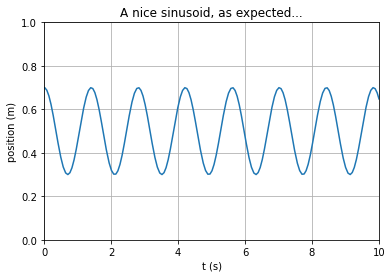

In [3]:
x0=np.array([0.7,0])
inputs={'xip1': lambda t: 1.,
        'xim1': lambda t: 0.}
sol = solve_ivp(fun=odefun_single,
                y0=x0, t_span=[0.,10.],
                method='RK45', atol=1e-6, rtol=1e-6,
                args=(inputs,))

plt.figure()
plt.plot(sol.t, sol.y[0,:])
plt.grid();
plt.ylim(0,1);plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.title('A nice sinusoid, as expected...');

We will now build the partitionned approach to solve the original two-mass system, using two one-mass solvers.

We will define a `SpringMassCoupler` class, which inherits the base `Coupler` class provided by `Rhapsopy`. It will be responsible for handling the communication with the susbsystem-solvers.

To understand what this class is reponsible for, let us consider a simplified sequence of events that occur during a coupling step from time $t_n$ to $t_{n+1}$:

1. We know the various state vectors $X_{i,n}$ of the subsystems at time $t_n$.
2. We compute the corresponding coupling variables $U_{i,n}$.
3. These are used, in conjunction with the previous values $U_{i,n-j},~j \in [1,p]$ to construct a polynomial extrapolation of their time evolution $\hat{U}_i(t)$.
4. Each subsystem is integrated forward in time from $t_n$ to $t_{n+1}$, using the required predicted coupling variables.
5. We retrieve the new state vectors $X_{i,n+1}$.

*Note that an implicit coupling can be achieved by looping over this process multiple times. This this will be dealt in one of the subsequent tutorials !*

The `SpringMassCoupler` class must provide various elements to enable the previous process. Let us list them:
1. A function that uses the subsystem data to compute the coupling variables. In our case, it must simply return the positions of both masses.
2. A function to integrate each subsystem separately. This function must take as input the polynomial predictions and spread them into the various solvers so that they can use them.

In [4]:
from rhapsopy.coupling import BaseCoupler
from rhapsopy.accelerators import ExplicitSolver
class SpringMassCoupler(BaseCoupler):
    def __init__(self,k,m):
        self.k = k
        self.m = m
        self.nCouplingVars = 2 # we have 2 coupling variables: the positions of both masses
        self.nSubsystems   = 2 # we have 2 coupled subsystems
        
    def getCouplingVars(self,t,y):
        """ Return the coupling variables, which are simply the speed and positions of the nodes.
            Here y denotes the global state vector, which the concatenation of each subsystem's state vector:
                y = [x_1, v_1, x_2, v_2]   """
        return y[::2]

    def integrateSingleSubsystem(self, isolv, t0, y0, dt, preds, rtol=None, bDebug=False):
        """ Performs one iteration of a coupling step, i.e. returns the value of the overall state vector at time t+dt,
            starting from state y at time t, with `preds` as inputs. The argument `preds` is a list of function handles
            which can be called to evaluate the polynomial coupling variables approximations. Here, preds[0] is the predicted
            position of the second mass (i.e. the input for the first mass subsystem), and preds[1] is the predicted position
            of the first mass (i.e. the input for the second mass subsystem). The ordering of preds is the same as that of the
            coupling variables returned by `getCouplingVars`.
        """
        # get each subsystem's state vector
        y0_subsystems = [y0[2*i:2*(i+1)] for i in range(2)]
        
        # Distribute the predictions
        current_input = {}
        if isolv==0: # first mass
            current_input['xim1'] = lambda t: 0. # left attachment point
            current_input['xip1'] = lambda t: preds[1].evaluate(t)
        else: # second mass
            current_input['xim1'] = lambda t: preds[0].evaluate(t)
            current_input['xip1'] = lambda t: 1. # right attachment point

        # perform time integration
        if rtol is None: rtol=1e-6
        atol = rtol
        current_out = solve_ivp(fun=lambda t,y : odefun_single(t, y, inputs=current_input),
                                y0=y0_subsystems[isolv], t_span=[t0,t0+dt],
                                max_step=dt, first_step=dt/2, # using first_step=dt sometimes causes an error in Scipy
                                method='RK45', atol=atol, rtol=rtol)
        if not current_out.success:
            raise Exception(current_out.message)
        return current_out

We can now test this first model ! To do so, we instantiate the class `Orchestrator` provided by `Rhapsopy`. This class implements all the details of the coupling algorithm. We must simply provide it with our `Coupler`object, and with the desired order of accuracy for the coupling variables.

In [5]:
from rhapsopy.coupling import Orchestrator

coupler = SpringMassCoupler(k=k,m=m)
y0_global = np.array([0.3, 0, 0.8, 0]) # initial state
tf = 10. # physical time to be simulated

conductor = Orchestrator(coupler=coupler, order=3)
conductor.interfaceSolver = ExplicitSolver # we first test a purely explicit coupling algorithm

nt = 200 # number of time steps
solcoupled = conductor.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt)) # fixed time step simulation
print(sol.message)
assert solcoupled.success, 'solution failed'

The solver successfully reached the end of the integration interval.


Let us compare it with the monolithic solution:

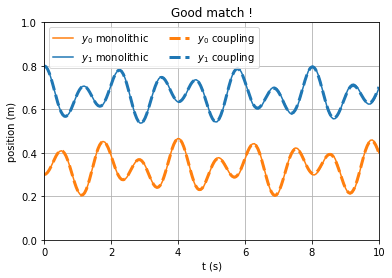

In [6]:
A=np.array(((0.,1,0,0),
            (-2*k/m,0,k/m,0),
            (0,0,0,1),
            (k/m,0,-2*k/m,0)))
def coupled_ode(t,y):
    return A @ y + np.array((0.,0,0,k/m))

sol = solve_ivp(fun=coupled_ode,
                y0=y0_global, t_span=[0.,10.],
                method='RK45', atol=1e-6, rtol=1e-6)

plt.figure()
plt.plot(sol.t, sol.y[0,:], color='tab:orange', label=r'$y_0$ monolithic')
plt.plot(sol.t, sol.y[2,:], color='tab:blue', label=r'$y_1$ monolithic')
plt.plot(solcoupled.t, solcoupled.y[0,:], color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ coupling')
plt.plot(solcoupled.t, solcoupled.y[2,:], color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ coupling')
plt.ylim(0,1)
plt.legend(ncol=2)
plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('t (s)')
plt.ylabel('position (m)')
plt.title('Good match !');

There you have it, your first coupled simulation with the `Rhapsopy` package. Well done !

### Effect of the prediction order
Finally, another aspect to consider is the order of the predictions. Increasing it very often improves the overall accuracy and allows for larger time steps to be performed without losing precision.
It may however decrease the stability of the coupling.
Here is a quick test that shows how our coupled simulation behaves with different orders for various numbers of time steps.

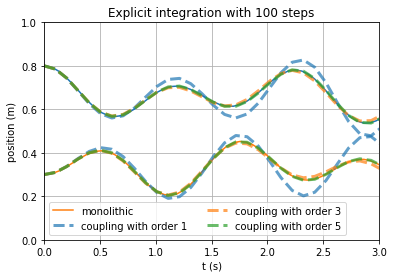

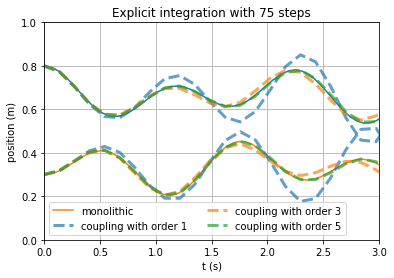

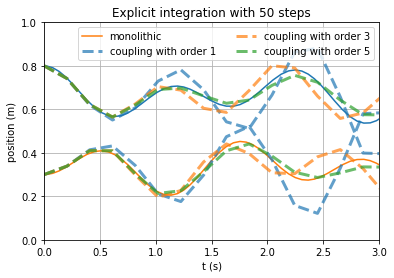

In [7]:
from rhapsopy.coupling import Orchestrator

coupler = SpringMassCoupler(k=k,m=m)
y0_global = np.array([0.3, 0, 0.8, 0])
tf = 10.

for nt in [100,75,50]: # number of time steps to be tested
    plt.figure()
    plt.plot(sol.t, sol.y[0,:], color='tab:orange', label=r'monolithic')
    plt.plot(sol.t, sol.y[2,:], color='tab:blue', label=None)
    for order in [1,3,5]: # orders to be tested
        conductor = Orchestrator(coupler=coupler, order=order)
        conductor.interfaceSolver = ExplicitSolver

        solcoupled = conductor.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))
        p,=plt.plot(solcoupled.t, solcoupled.y[0,:], linestyle='--', linewidth=3,
                    label=f'coupling with order {order}', alpha=0.7)
        plt.plot(solcoupled.t, solcoupled.y[2,:], color=p.get_color(), linestyle='--', linewidth=3,
                 label=None, alpha=0.7)
    plt.ylim(0,1)
    plt.xlim(0,3.)
    plt.legend(ncol=2)
    plt.grid()
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.title(f'Explicit integration with {nt} steps')